# Factor Estimation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Import Data

Monthly financial information: average price, return, shares outstanding, etc.

Quarterly financial information: asset, common/ordinary equity, earnings per share, income before extraordinary items, etc.

In [20]:
nasdaq100 = pd.read_excel("nasdaq100_pop.xlsx", sheet_name="all")
monthly = pd.read_excel("monthly data.xlsx")
quarterly = pd.read_excel("quarterly data.xlsx")
ff_factors = pd.read_excel("datasets.xlsx", sheet_name="ff_factors")

In [21]:
nasdaq100 = nasdaq100.rename(columns={'COMNAM': 'Company Name', 
                                      'TICKER': 'Ticker Symbol',
                                      'GVKEY': 'Global Company Key'})

monthly.rename(columns={"Returns": "RET", 
                        "Excess Return on the Market": "MKTRF", 
                        "Risk-Free Return Rate (One Month Treasury Bill Rate)": "RF"},
               inplace=True)

monthly.dropna(subset=['Company Name'], inplace=True)

ff_factors.rename(columns={"Excess Return on the Market": "MKTRF", 
                           "Small-Minus-Big Return": "SMB", 
                           "High-Minus-Low Return": "HML", 
                           "Risk-Free Return Rate (One Month Treasury Bill Rate)": "RF", 
                           "Momentum Factor": "MOM", 
                           "Date (SAS). Last Trading Day of the Month": "Names Date"}, 
                  inplace=True)

In [4]:
nasdaq100.head()

,PERMNO,Company Name,Ticker Symbol,Global Company Key,TIC
0,14593,APPLE INC,AAPL,1690,AAPL
1,20190,AIRBNB INC,ABNB,37460,ABNB
2,75510,ADOBE INC,ADBE,12540,ADBE
3,60871,ANALOG DEVICES INC,ADI,1632,ADI
4,44644,AUTOMATIC DATA PROCESSING INC,ADP,1891,ADP


In [5]:
monthly.head()

,PERMNO,Names Date,Ticker Symbol,Company Name,CUSIP Header,Price or Bid/Ask Average,Returns,Shares Outstanding,Returns without Dividends,Value-Weighted Return-incl. dividends,Return on the S&P 500 Index
0,10107,1997-01-31,MSFT,MICROSOFT CORP,59491810,102.0000,0.234493,1198000.0,0.234493,0.053473,0.061317
1,10107,1997-02-28,MSFT,MICROSOFT CORP,59491810,97.5000,-0.044118,1198000.0,-0.044118,-0.001067,0.005928
2,10107,1997-03-31,MSFT,MICROSOFT CORP,59491810,91.6875,-0.059615,1191000.0,-0.059615,-0.044889,-0.042614
3,10107,1997-04-30,MSFT,MICROSOFT CORP,59491810,121.5000,0.325153,1191000.0,0.325153,0.042396,0.058406
4,10107,1997-05-30,MSFT,MICROSOFT CORP,59491810,124.0000,0.020576,1191000.0,0.020576,0.071640,0.058577


In [6]:
quarterly.head()

,Global Company Key,Data Date,Fiscal Year,Fiscal Quarter,Industry Format,Level of Consolidation - Company Interim Descriptor,Population Source,Data Format,Ticker Symbol,Company Name,ISO Currency Code,Calendar Data Year and Quarter,Fiscal Data Year and Quarter,Assets - Total,Common/Ordinary Equity - Total,Earnings Per Share (Basic) - Excluding Extraordinary Items,Income Before Extraordinary Items,Sales/Turnover (Net),Active/Inactive Status Marker
0,1161,1996-03-31,1996,1.0,INDL,C,D,STD,AMD,ADVANCED MICRO DEVICES,USD,1996Q1,1996Q1,2954.809,2121.948,0.18,25.327,544.212,A
1,1161,1996-06-30,1996,2.0,INDL,C,D,STD,AMD,ADVANCED MICRO DEVICES,USD,1996Q2,1996Q2,2845.025,2071.355,-0.26,-34.672,455.077,A
2,1161,1996-09-30,1996,3.0,INDL,C,D,STD,AMD,ADVANCED MICRO DEVICES,USD,1996Q3,1996Q3,3053.992,2036.658,-0.28,-38.362,456.862,A
3,1161,1996-12-31,1996,4.0,INDL,C,D,STD,AMD,ADVANCED MICRO DEVICES,USD,1996Q4,1996Q4,3145.283,2021.878,-0.15,-21.243,496.868,A
4,1161,1997-03-31,1997,1.0,INDL,C,D,STD,AMD,ADVANCED MICRO DEVICES,USD,1997Q1,1997Q1,3426.126,2043.757,0.09,12.951,551.999,A


## Data Processing

In [8]:
### Merge the tables

merged_gvkey = pd.merge(monthly,nasdaq100[['Global Company Key','PERMNO']],
                  on='PERMNO', how='inner')

quarterly['report_date'] = quarterly['Data Date'] + pd.DateOffset(months=3)

merged = pd.merge_asof(merged_gvkey.sort_values('Names Date'),
                      quarterly[['Global Company Key',
                                 'Data Date',
                                 'report_date',
                                 'Calendar Data Year and Quarter',
                                 'Assets - Total', 
                                 'Common/Ordinary Equity - Total', 
                                 'Earnings Per Share (Basic) - Excluding Extraordinary Items', 
                                 'Income Before Extraordinary Items', 
                                 'Sales/Turnover (Net)']].sort_values('report_date'),
                      left_on='Names Date',
                      right_on='report_date',
                      by='Global Company Key')

In [9]:
merged = merged[(merged['Names Date'].dt.year >= 2000) & (merged['Names Date'].dt.year <= 2022)]

## Create Additional Variables

#### Firm Size Proxy

In [11]:
merged.dropna(subset=['Price or Bid/Ask Average'], inplace=True)
merged.dropna(subset=['Shares Outstanding'], inplace=True)
merged['Market Value'] = merged['Price or Bid/Ask Average'] * merged['Shares Outstanding'] * 1000

merged['lnSize'] = np.log(merged['Market Value'])

C:\Users\willi\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Firm Size Proxy')

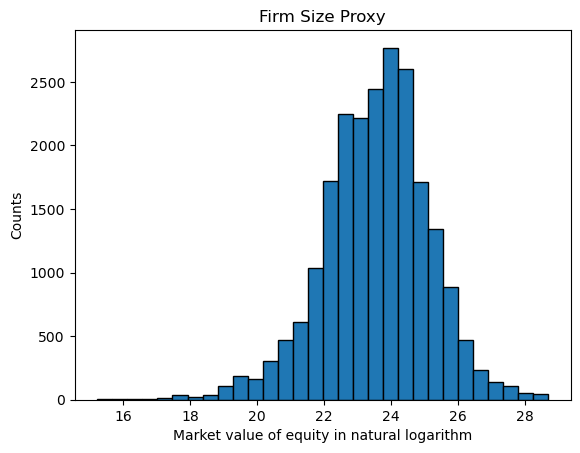

In [12]:
plt.hist(merged['lnSize'], bins=30, histtype='bar', ec='black')

plt.xlabel("Market value of equity in natural logarithm")
plt.ylabel("Counts")

plt.title("Firm Size Proxy")

#### Value Proxy One

In [14]:
merged['Booked Value'] = merged['Common/Ordinary Equity - Total'] * 1000000
merged['bk2mkt'] = merged['Booked Value'] / merged['Market Value']

Text(0.5, 1.0, 'Firm Value Proxy One')

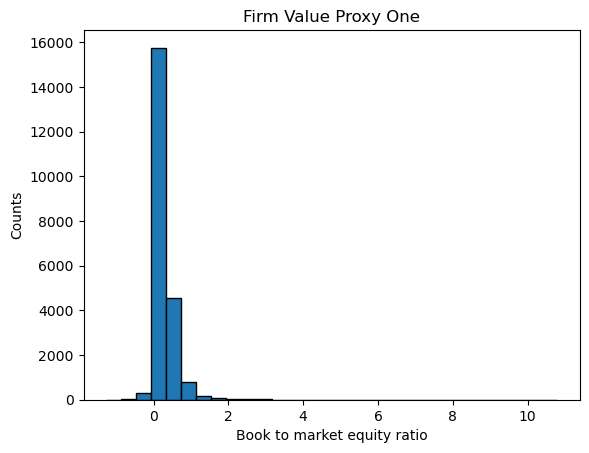

In [15]:
plt.hist(merged['bk2mkt'], bins=30, histtype='bar', ec='black')

plt.xlabel("Book to market equity ratio")
plt.ylabel("Counts")

plt.title("Firm Value Proxy One")

#### Value Proxy Two

In [16]:
merged['eP'] = merged['Income Before Extraordinary Items'] * 1000000 / merged['Market Value']

Text(0.5, 1.0, 'Firm Value Proxy One')

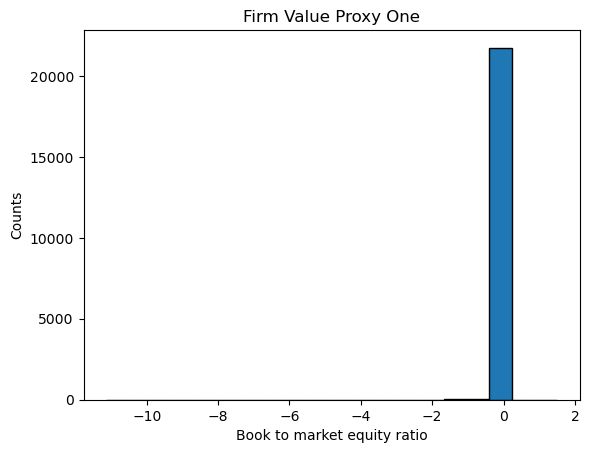

In [18]:
plt.hist(merged['eP'], bins=20, histtype='bar', ec='black')

plt.xlabel("Book to market equity ratio")
plt.ylabel("Counts")

plt.title("Firm Value Proxy One")

#### Estimate Beta

In [22]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from scipy import stats

In [27]:
### changing the DATE column into yyyymm format and also a monthid format
monthly['yyyymm'] = monthly['Names Date'].dt.year*100 + monthly['Names Date'].dt.month
ff_factors['yyyymm'] = ff_factors['Names Date'].dt.year*100 + ff_factors['Names Date'].dt.month

### merge the fama french factors to the monthly data
monthly= pd.merge(monthly,ff_factors[['MKTRF', 'RF', 'yyyymm']],
                  on='yyyymm', how='left')

monthly['XRET'] = monthly['RET'] - monthly['RF']

In [28]:
### group by companies, run linear regressions on each company
permno_groups = monthly.groupby(["PERMNO"])

beta = []

# Running the CAPM using linear regression
for name, group in permno_groups:
    for i in range(len(group)):
        if i < 11:    ### fewer than 12 observations, missing beta 
            beta.append(np.nan)
        elif i < 35:  ### 12 to 35 observations
            table = monthly[['MKTRF', 'XRET']].iloc[0:i+1]
            CAPMmodel = linear_model.LinearRegression().fit(table[['MKTRF']], table["XRET"])
            beta.append(CAPMmodel.coef_[0])
        else:         ### 36 observations
            table = monthly[['MKTRF', 'XRET']].iloc[i-35:i+1]
            CAPMmodel = linear_model.LinearRegression().fit(table[['MKTRF']], table["XRET"])
            beta.append(CAPMmodel.coef_[0])

monthly['beta'] = pd.Series(beta)

#### Estimate Idiosyncratic Volatility

In [29]:
daily = pd.read_excel("daily data.xlsx")

In [30]:
daily.head()

,PERMNO,Names Date,Returns
0,10107,2000-01-03,-0.001606
1,10107,2000-01-04,-0.033780
2,10107,2000-01-05,0.010544
3,10107,2000-01-06,-0.033498
4,10107,2000-01-07,0.013068


In [31]:
### import fama french daily data
ff_daily = pd.read_excel("ff_factors daily.xlsx")

ff_daily.rename(columns={"Excess Return on the Market": "MKTRF", 
                         "Small-Minus-Big Return": "SMB", 
                         "High-Minus-Low Return": "HML", 
                         "Risk-Free Return Rate (One Month Treasury Bill Rate)": "RF", 
                         "Momentum Factor": "MOM"}, 
                inplace=True)

In [32]:
ff_daily.head()

,Date,MKTRF,SMB,HML,RF,Momentum
0,2000-01-03,-0.0071,0.0062,-0.0141,0.00021,-0.0008
1,2000-01-04,-0.0406,0.0000,0.0206,0.00021,-0.0191
2,2000-01-05,-0.0009,0.0020,0.0016,0.00021,-0.0049
3,2000-01-06,-0.0073,-0.0043,0.0126,0.00021,-0.0149
4,2000-01-07,0.0321,-0.0048,-0.0142,0.00021,0.0056


In [33]:
### merge the daily fama french data to daily trading data
daily['yyyymm'] = daily['Names Date'].dt.year*100 + daily['Names Date'].dt.month
ff_daily['yyyymm'] = ff_daily['Date'].dt.year*100 + ff_daily['Date'].dt.month

merge_2 = pd.merge(daily,ff_daily[['Date', 'MKTRF', 'SMB', 'HML', 'RF']],
                   left_on='Names Date', right_on='Date', how='left')

merge_2['XRET'] = merge_2['Returns'] - merge_2['RF']
merge_2.dropna(subset=['XRET'], inplace=True)

In [34]:
merge_2.head()

,PERMNO,Names Date,Returns,yyyymm,Date,MKTRF,SMB,HML,RF,XRET
0,10107,2000-01-03,-0.001606,200001,2000-01-03,-0.0071,0.0062,-0.0141,0.00021,-0.001816
1,10107,2000-01-04,-0.033780,200001,2000-01-04,-0.0406,0.0000,0.0206,0.00021,-0.033990
2,10107,2000-01-05,0.010544,200001,2000-01-05,-0.0009,0.0020,0.0016,0.00021,0.010334
3,10107,2000-01-06,-0.033498,200001,2000-01-06,-0.0073,-0.0043,0.0126,0.00021,-0.033708
4,10107,2000-01-07,0.013068,200001,2000-01-07,0.0321,-0.0048,-0.0142,0.00021,0.012858


In [35]:
### group by each company in each month
stock_month = merge_2.groupby(["PERMNO", "yyyymm"])

permno = []
months = []
ivol = []

# Estimating the Fama-French three-factor model and saving the regression residuals
for name, group in stock_month:
    permno.append(name[0])
    months.append(name[1])
    
    if len(group) < 10:
        ivol.append(np.nan)
    else:
        ff3model = linear_model.LinearRegression().fit(group[["MKTRF", "SMB", "HML"]], 
                                                       group["XRET"])
        predicts = []
        for i in range(len(group)):
            predict = ff3model.predict(group.iloc[i: i+1][["MKTRF", "SMB", "HML"]])
            predicts.append(predict[0])
        
        residuals = np.array(predicts) - group['XRET']
        ivol.append(residuals.std())
        

In [36]:
monthly_ivol = {'PERMNO': permno,
                'yyyymm': months,
                'ivol': ivol
               }

df_ivol = pd.DataFrame(monthly_ivol)
df_ivol.head()

,PERMNO,yyyymm,ivol
0,10107,200001,0.023474
1,10107,200002,0.017771
2,10107,200003,0.031297
3,10107,200004,0.037296
4,10107,200005,0.016864


#### Estimate Momentum

In [37]:
### group by each company
permno_groups = monthly.groupby(["PERMNO"])

mom = []

# Calculating momentum characteristic of each stock
# Note that RET is null for the first month of each stock
# Treat other null value as 0
for name, group in permno_groups:
    for i in range(len(group)):
        if i < 10:     ### fewer than 10 observations, missing mom 
            mom.append(np.nan)
        elif i < 12:  ### 10 or 11 observations
            cumulative = 1
            for j in range(1, i+1):
                ret  = group['RET'].iloc[j]
                cumulative = cumulative * (1 + ret)
            mom.append(cumulative-1)
        else:         ### use 12 observations to calculate cumulative (compound) returns
            cumulative = 1
            for j in range(i-11, i+1):
                ret  = group['RET'].iloc[j]
                cumulative = cumulative * (1 + ret)
            mom.append(cumulative-1)

monthly['mom'] = pd.Series(mom)